In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import scipy.optimize
import model_graddesc as model


torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[10., 0.], [0, 5.]]
origin_target = [[0.,5.], [10.,-5.]]

target = mm.multipleCircles(origin_target, radius, nb_pts)

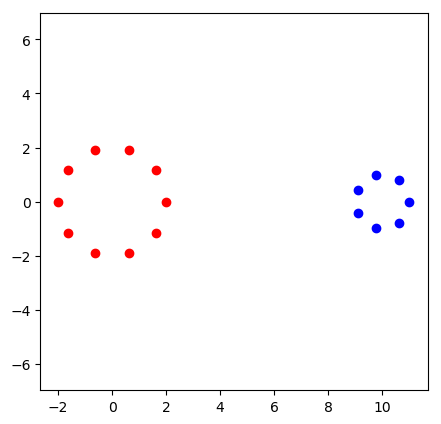

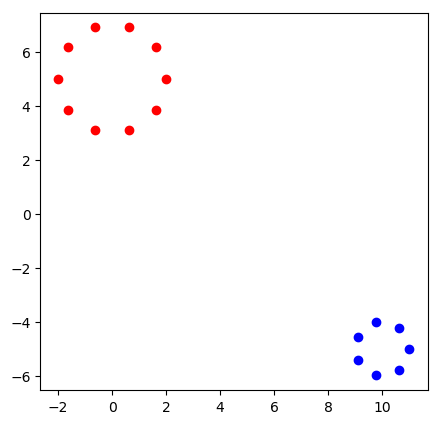

In [5]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [8]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
mod1 = dm.deformationmodules.CompoundModule([trans1])

sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
mod2 = dm.deformationmodules.CompoundModule([trans2])

module_list = [mod1, mod2]
sigma_bg = 1.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [9]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [10]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat([source[0], source[1], source[0], source[1]],0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)
X = [gd0_tensor, mom0_tensor]

In [11]:
def fun(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()

def jac(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()


args = [EnergyFunctional]

P = mom0_tensor.detach().numpy()

In [12]:
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  #'maxcor': 10,
                                  #'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  #'maxfun': 500,
                                  'maxiter': 100,
                                  #'iprint': 1,
                                  #'maxls': 25
                              })

../defmod/deformationmodules.py:99: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)


RuntimeError: invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view(). at /opt/conda/conda-bld/pytorch-cpu_1556653075177/work/aten/src/TH/generic/THTensor.cpp:203

In [15]:
X[1] = torch.tensor(res.x)

../defmod/deformationmodules.py:95: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ = torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), self.__coeff * K_q)
../defmod/multishape.py:190: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same R

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

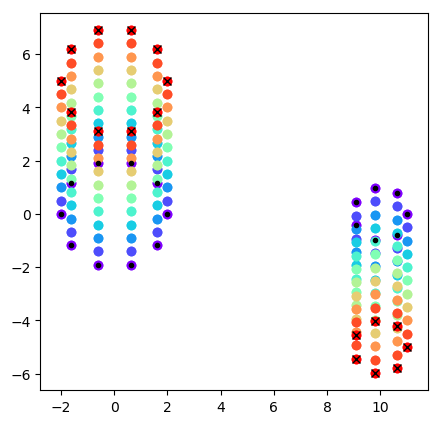

In [16]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

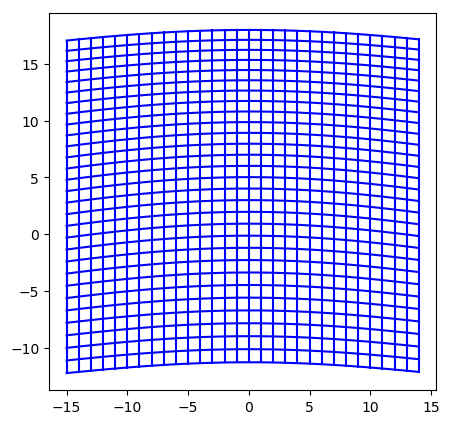

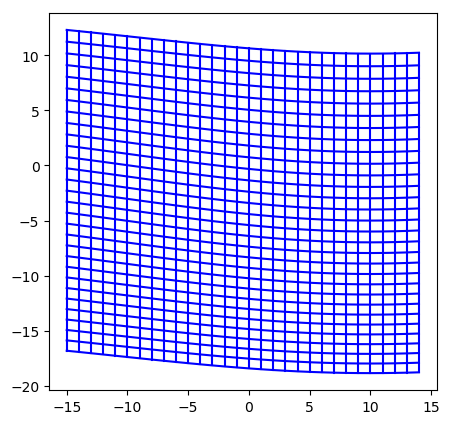

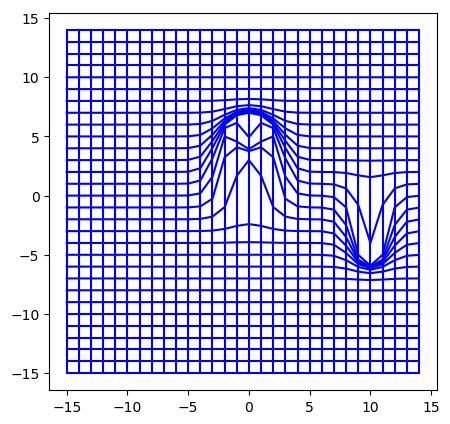

In [17]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()


In [18]:
modules.manifold.gd

[[tensor([ 2.0000,  4.5000,  1.6180,  5.6756,  0.6180,  6.4021, -0.6180,  6.4021,
          -1.6180,  5.6756, -2.0000,  4.5000, -1.6180,  3.3244, -0.6180,  2.5979,
           0.6180,  2.5979,  1.6180,  3.3244], requires_grad=True)],
 [tensor([11.0000, -4.5000, 10.6235, -3.7182,  9.7775, -3.5251,  9.0990, -4.0661,
           9.0990, -4.9339,  9.7775, -5.4749, 10.6235, -5.2818],
         requires_grad=True)],
 [tensor([ 2.0000,  4.5000,  1.6180,  5.6756,  0.6180,  6.4021, -0.6180,  6.4021,
          -1.6180,  5.6756, -2.0000,  4.5000, -1.6180,  3.3244, -0.6180,  2.5979,
           0.6180,  2.5979,  1.6180,  3.3244], requires_grad=True),
  tensor([11.0000, -4.5000, 10.6235, -3.7182,  9.7775, -3.5251,  9.0990, -4.0661,
           9.0990, -4.9339,  9.7775, -5.4749, 10.6235, -5.2818],
         requires_grad=True)]]

In [9]:
def compute_deformation_grid(grid_origin, grid_size, grid_resolution, it=2, intermediate=False):
    x, y = torch.meshgrid([
        torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
        torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

    gridpos = dm.usefulfunctions.grid2vec(x, y)

    grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
    grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)

    intermediate = dm.shooting.shoot_euler(dm.hamiltonian_multishape.Hamiltonian_multi(dm.multishape.MultiShapeModule([grid_silent, *modules.module_list]), constr_Id), it=10)

    return dm.usefulfunctions.vec2grid(grid_landmarks.gd.view(-1, 2).detach(), grid_resolution[0], grid_resolution[1])

compute_deformation_grid(torch.tensor([-3.,-3.]), torch.tensor([15.,10.]), torch.Size([16,16]))

AttributeError: 'SilentPoints' object has no attribute 'module_list'

In [ ]:
fig_shooting.savefig('results/circles_translation/shooting.png')
fig_source.savefig('results/circles_translation/source.png')
fig_target.savefig('results/circles_translation/target.png')

fig_grid1.savefig('results/circles_translation/grid1.png')
fig_grid2.savefig('results/circles_translation/grid2.png')
fig_grid_bg.savefig('results/circles_translation/grid_bg.png')